In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
x.shape

(50,)

In [4]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [5]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # get k'th subgroup in test, others in train:
    test_indices = k_indices[k]
    train_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
    
    x_test = x[test_indices]
    x_train = x[train_indices]
    y_test = y[test_indices]
    y_train = y[train_indices]
    # ***************************************************
    
    # ***************************************************
    # form data with polynomial degree:
    x_train_poly = build_poly(x_train, degree)
    x_test_poly = build_poly(x_test, degree)
    # ***************************************************
    
    
    # ***************************************************
    # ridge regression:
    wstar = ridge_regression(y_train, x_train_poly, lambda_)
    # ***************************************************

    # ***************************************************
    # calculate the loss for train and test data:
    loss_tr = np.sqrt(2*compute_mse(y_train, x_train_poly, wstar))
    loss_te = np.sqrt(2*compute_mse(y_test, x_test_poly, wstar))
    # ***************************************************
    
    return loss_tr, loss_te, wstar

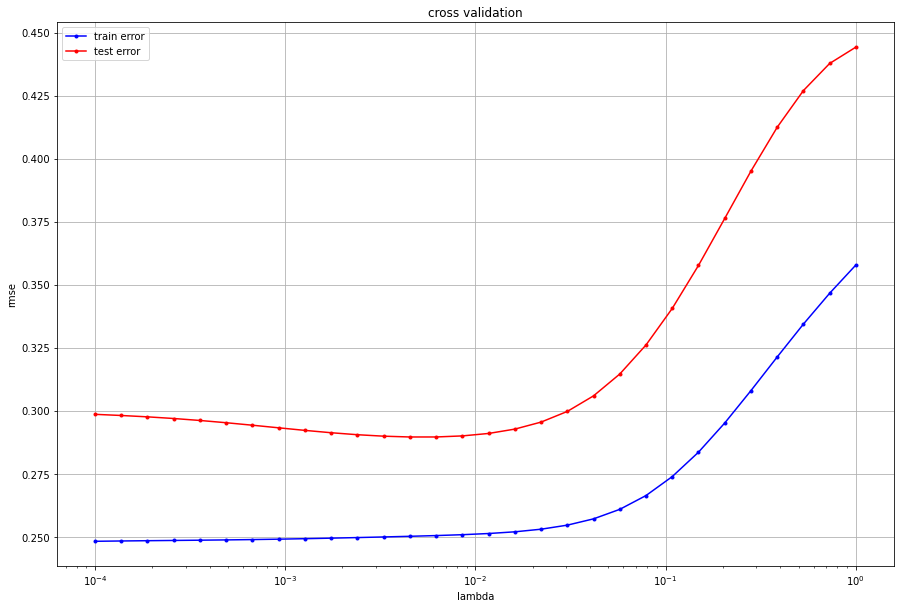

In [6]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    for lambda_ in lambdas:
        loss_tr_lambda = []
        loss_te_lambda = []
        
        for k in range(k_fold):
            loss_tr, loss_te, _ = cross_validation(y, x, k_indices, k, lambda_, degree)
            loss_tr_lambda.append(loss_tr)
            loss_te_lambda.append(loss_te)
            
        rmse_tr.append(np.mean(loss_tr_lambda))
        rmse_te.append(np.mean(loss_te_lambda))
    # ***************************************************    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

**Selection of the best model among various degrees:**

In [20]:
def select_model(y, x, degrees, k_fold, lambdas, seed=1):
    #split the data
    k_indices = build_k_indices(y, k_fold, seed)

    #for each degree, we compute the best lambdas and the associated rmse
    best_lambdas = []
    best_rmses = []
    # for each degree
    for degree in degrees:
        #cross validation
        loss_te_degree = []
    
        for lambda_ in lambdas:
            loss_te_lambda = []
            
            for k in range(k_fold):
                _, loss_te, _ = cross_validation(y, x, k_indices, k, lambda_, degree)
                loss_te_lambda.append(loss_te)

            loss_te_degree.append(np.mean(loss_te_lambda))
        
        #index of best lambda for given degree
        ind_lambda_opt = np.argmin(loss_te_degree)
        ##append the best loss and best corresponding lambda for degree
        best_lambdas.append(lambdas[ind_lambda_opt])
        best_rmses.append(loss_te_degree[ind_lambda_opt])
        
    ind_opt = np.argmin(best_rmses)
    
    return degrees[ind_opt], lambdas[ind_opt]

In [21]:
select_model(y, x, np.arange(2,11), 4, np.logspace(-4, 0, 30))

(7, 0.0004893900918477494)

**Box-plot of the RMSE using the cross-validation:**

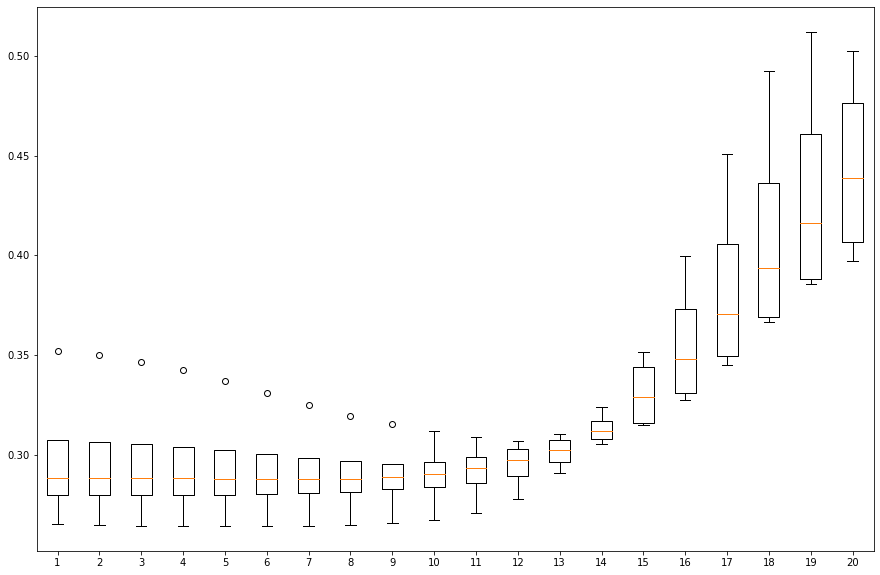

In [9]:
def extended_cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 20)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    variances = []
    
    # cross validation
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        
        for k in range(k_fold):
            loss_tr, loss_te,_ = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            
        rmse_tr.append(rmse_tr_tmp)
        rmse_te.append(rmse_te_tmp)
        variances.append(loss_te)
    
    plt.figure(figsize=(15,10))
    plt.boxplot(rmse_te)

extended_cross_validation_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

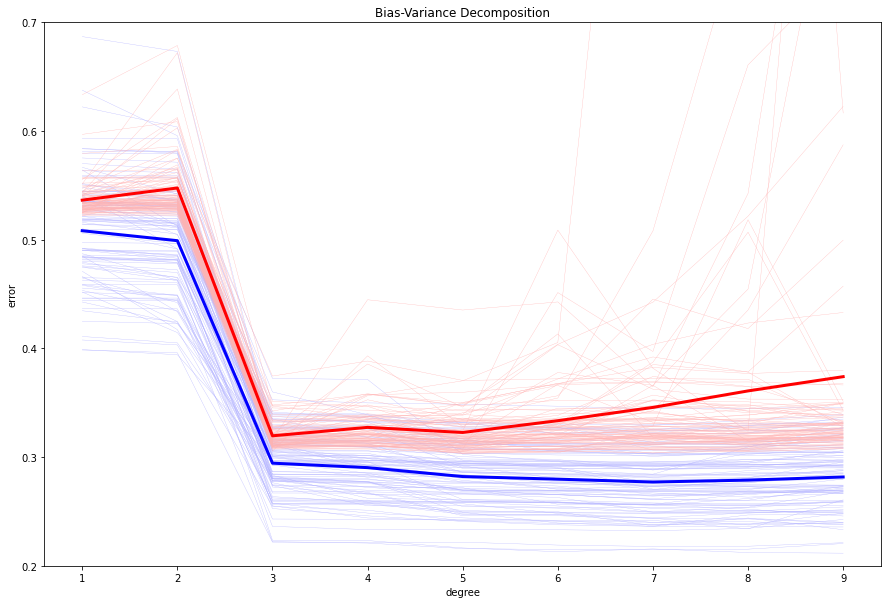

In [38]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # split data with a specific seed:
        x_train, y_train, x_test, y_test = split_data(x, y, ratio_train, seed)
        # ***************************************************

        # *************************************************** 
        # bias_variance_decomposition:
        for index_degree, degree in enumerate(degrees):
            # form polynomial data
            tx_train = build_poly(x_train, degree)
            tx_test = build_poly(x_test, degree)
            # least square
            w, _ = least_squares(y_train, tx_train)
            # calculate the rmse for train and test
            rmse_tr[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_train, tx_train, w))
            rmse_te[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_test, tx_test, w))
        
        # ***************************************************

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()